# MLPRegressor

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_absolute_error, mean_squared_error
from statsmodels.tools.eval_measures import stde

import kerastuner as kt
import tensorflow as tf
from tensorflow.keras import models


2022-11-25 12:40:19.437220: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-25 12:40:19.676917: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-25 12:40:20.172658: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/nkspartan/miniconda3/envs/tf-gpu/lib/
2022-11-25 12:40:20.172768: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfe

In [2]:
from tensorflow.python.client import device_lib

print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

2022-11-25 12:40:20.725222: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-25 12:40:20.734914: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-25 12:40:20.739384: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-25 12:40:20.739582: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

Default GPU Device: /device:GPU:0


## Read the etl info results

In [3]:
df_info = pd.read_csv('../dataset_clean/options_csv_v1_etl.csv')
df_info

,remove_time_features,generic_features,remove_atypical_values,feature_combination,remove_feature_selection,remove_invalid_correlated_features
0,False,True,False,False,Lasso,False


## Read the dataset

In [4]:
df = pd.read_csv('../dataset/Seresnet_101_V1_PlatteRiverWeir_features_merged_all.csv')
df

,Unnamed: 0.1,Unnamed: 0,SensorTime,CaptureTime,Filename,Agency,SiteNumber,TimeZone,Stage,Discharge,...,WwRawLineMax,WwRawLineMean,WwRawLineSigma,WwCurveLineMin,WwCurveLineMax,WwCurveLineMean,WwCurveLineSigma,RiverArea,RiverWidth,FilenameLower
0,0,0,2012-06-09 13:15:00,2012-06-09T13:09:07,StateLineWeir_20120609_Farrell_001.jpg,USGS,6674500,MDT,2.99,916.0,...,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,48600.0,204.684959,statelineweir_20120609_farrell_001.jpg
1,1,1,2012-06-09 13:15:00,2012-06-09T13:10:29,StateLineWeir_20120609_Farrell_002.jpg,USGS,6674500,MDT,2.99,916.0,...,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,48672.0,205.898452,statelineweir_20120609_farrell_002.jpg
2,2,2,2012-06-09 13:45:00,2012-06-09T13:44:01,StateLineWeir_20120609_Farrell_003.jpg,USGS,6674500,MDT,2.96,873.0,...,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,48789.0,206.525571,statelineweir_20120609_farrell_003.jpg
3,3,3,2012-06-09 14:45:00,2012-06-09T14:44:30,StateLineWeir_20120609_Farrell_004.jpg,USGS,6674500,MDT,2.94,846.0,...,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,49458.0,209.652156,statelineweir_20120609_farrell_004.jpg
4,4,4,2012-06-09 15:45:00,2012-06-09T15:44:59,StateLineWeir_20120609_Farrell_005.jpg,USGS,6674500,MDT,2.94,846.0,...,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,49719.0,210.088266,statelineweir_20120609_farrell_005.jpg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42054,42054,42054,2019-10-11 09:00:00,2019-10-11T08:59:53,StateLineWeir_20191011_Farrell_409.jpg,USGS,6674500,MDT,2.54,434.0,...,77521.0,38385.370066,15952.029728,0.0,70085.0,37550.894823,16444.401209,41501.0,166.685071,statelineweir_20191011_farrell_409.jpg
42055,42055,42055,2019-10-11 10:00:00,2019-10-11T09:59:52,StateLineWeir_20191011_Farrell_410.jpg,USGS,6674500,MDT,2.54,434.0,...,74614.0,40162.989292,15467.708856,0.0,70061.0,39397.339095,16009.008049,41591.0,171.758237,statelineweir_20191011_farrell_410.jpg
42056,42056,42056,2019-10-11 11:00:00,2019-10-11T10:59:52,StateLineWeir_20191011_Farrell_411.jpg,USGS,6674500,MDT,2.54,434.0,...,83260.0,42095.946590,16770.357949,0.0,76335.0,41350.006568,17489.374617,41949.0,176.424371,statelineweir_20191011_farrell_411.jpg
42057,42057,42057,2019-10-11 12:00:00,2019-10-11T11:59:53,StateLineWeir_20191011_Farrell_412.jpg,USGS,6674500,MDT,2.54,434.0,...,83045.0,45345.490954,17498.432849,0.0,78882.0,44553.920296,18268.294896,42822.0,172.268391,statelineweir_20191011_farrell_412.jpg


In [5]:
df['SensorTime'] = pd.to_datetime(df['SensorTime'])
df['Year'] = df['SensorTime'].dt.year
df['Month'] = df['SensorTime'].dt.month
df['date_offset'] = (df.SensorTime.dt.month * 100 + df.SensorTime.dt.day - 320)%1300

df['Season'] = pd.cut(df['date_offset'], [0, 300, 602, 900, 1300], 
                      labels=['spring', 'summer', 'autumn', 'winter'])

In [6]:
df = df[["CaptureTime", "SensorTime", "Stage", "Discharge", "RiverArea", "RiverWidth", "Month", "Season", "Year"]]
df

,CaptureTime,SensorTime,Stage,Discharge,RiverArea,RiverWidth,Month,Season,Year
0,2012-06-09T13:09:07,2012-06-09 13:15:00,2.99,916.0,48600.0,204.684959,6,spring,2012
1,2012-06-09T13:10:29,2012-06-09 13:15:00,2.99,916.0,48672.0,205.898452,6,spring,2012
2,2012-06-09T13:44:01,2012-06-09 13:45:00,2.96,873.0,48789.0,206.525571,6,spring,2012
3,2012-06-09T14:44:30,2012-06-09 14:45:00,2.94,846.0,49458.0,209.652156,6,spring,2012
4,2012-06-09T15:44:59,2012-06-09 15:45:00,2.94,846.0,49719.0,210.088266,6,spring,2012
...,...,...,...,...,...,...,...,...,...
42054,2019-10-11T08:59:53,2019-10-11 09:00:00,2.54,434.0,41501.0,166.685071,10,autumn,2019
42055,2019-10-11T09:59:52,2019-10-11 10:00:00,2.54,434.0,41591.0,171.758237,10,autumn,2019
42056,2019-10-11T10:59:52,2019-10-11 11:00:00,2.54,434.0,41949.0,176.424371,10,autumn,2019
42057,2019-10-11T11:59:53,2019-10-11 12:00:00,2.54,434.0,42822.0,172.268391,10,autumn,2019


In [7]:
df.dtypes

CaptureTime            object
SensorTime     datetime64[ns]
Stage                 float64
Discharge             float64
RiverArea             float64
RiverWidth            float64
Month                   int64
Season               category
Year                    int64
dtype: object

### Remove outliers

In [8]:
df = df[df.Stage > 0]
df = df[df.Discharge > 0]
df.shape

(40148, 9)

In [9]:
df = df[df.RiverWidth > 0]
#df = df[df.Discharge > 0]
df.shape

(40142, 9)

### Remove winter

In [10]:
#df = df[df.Season != "winter"]

In [11]:
df.isna().sum()

CaptureTime      0
SensorTime       0
Stage            0
Discharge        0
RiverArea        0
RiverWidth       0
Month            0
Season         126
Year             0
dtype: int64

## Divide dataset to X and Y

In [12]:
np.random.seed(0)

df_train = df[(df.Year >= 2012) & (df.Year <= 2016)]
df_train = df_train.iloc[np.random.permutation(len(df_train))]

df_val = df[(df.Year >= 2017) & (df.Year <= 2017)]
df_val = df_val.iloc[np.random.permutation(len(df_val))]

df_test = df[(df.Year >= 2018) & (df.Year <= 2019)]

In [13]:
df_train = df_train.drop(columns=["Year", "SensorTime", "CaptureTime"])
df_val = df_val.drop(columns=["Year", "SensorTime", "CaptureTime"])
df_test = df_test.drop(columns=["Year", "SensorTime", "CaptureTime"])

In [14]:

y_train = df_train[["Stage"]].values
X_train = df_train[["RiverWidth", "Month"]].values

y_val = df_train[["Stage"]].values
X_val = df_train[["RiverWidth", "Month"]].values

y_test = df_test[["Stage"]].values
X_test = df_test[["RiverWidth", "Month"]].values


In [15]:
print(X_train.shape)
print(y_train.shape)

(20304, 2)
(20304, 1)


In [16]:
input_shape = X_train.shape[1]
output_shape = y_train.shape[1]

print(input_shape, output_shape)

2 1


## Train model

In [17]:
def model_builder(lr):
  model = tf.keras.Sequential()
  model.add(tf.keras.Input(shape=input_shape))
  
  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 32-512

  model.add(tf.keras.layers.Dense(32, activation="relu"))
  model.add(tf.keras.layers.Dense(64, activation="relu"))
  model.add(tf.keras.layers.Dense(128, activation="relu"))
  model.add(tf.keras.layers.Dense(64, activation="relu"))
  """model.add(tf.keras.layers.Dense(256, activation="tanh"))
  model.add(tf.keras.layers.Dense(512, activation="tanh"))
  model.add(tf.keras.layers.Dense(512, activation="tanh"))
  model.add(tf.keras.layers.Dense(256, activation="tanh"))
  model.add(tf.keras.layers.Dense(256, activation="tanh"))
  model.add(tf.keras.layers.Dense(128, activation="tanh"))
  model.add(tf.keras.layers.Dense(64, activation="tanh"))
  model.add(tf.keras.layers.Dense(32, activation="tanh"))"""


  model.add(tf.keras.layers.Dense(output_shape, activation = 'linear'))

  
  model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = lr), loss = 'mse', metrics = ['mse', tf.keras.metrics.RootMeanSquaredError(name='rmse'), 'mae', 'mape'])
  
  return model

In [18]:
model = model_builder(1e-3)

2022-11-25 12:40:22.166786: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-25 12:40:22.167093: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-25 12:40:22.167296: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-25 12:40:22.167977: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-25 12:40:22.168178: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from S

In [19]:
import datetime

date_actual = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = "logs/fit/" + date_actual
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=100)

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=f"model_weights/{date_actual}_mlp_seg_best_weights.hdf5",
                               monitor='val_loss',
                               verbose=1,
                               save_best_only=True)

In [20]:
model.fit(X_train, y_train, epochs = 2000, batch_size = 64, validation_data = (X_val, y_val), callbacks=[checkpoint_callback, es_callback, tf.keras.callbacks.ReduceLROnPlateau(patience=40)])

Epoch 1/2000
315/318 [============================>.] - ETA: 0s - loss: 1.5942 - mse: 1.5942 - rmse: 1.2626 - mae: 0.8093 - mape: 28.2478
Epoch 1: val_loss improved from inf to 0.69714, saving model to model_weights/20221125-124022_mlp_seg_best_weights.hdf5
318/318 [==============================] - 2s 4ms/step - loss: 1.5885 - mse: 1.5885 - rmse: 1.2604 - mae: 0.8088 - mape: 28.2368 - val_loss: 0.6971 - val_mse: 0.6971 - val_rmse: 0.8349 - val_mae: 0.5825 - val_mape: 18.0457 - lr: 0.0010
Epoch 2/2000
307/318 [===========================>..] - ETA: 0s - loss: 0.7022 - mse: 0.7022 - rmse: 0.8380 - mae: 0.6340 - mape: 21.7619
Epoch 2: val_loss improved from 0.69714 to 0.62361, saving model to model_weights/20221125-124022_mlp_seg_best_weights.hdf5
318/318 [==============================] - 1s 3ms/step - loss: 0.6995 - mse: 0.6995 - rmse: 0.8364 - mae: 0.6320 - mape: 21.6950 - val_loss: 0.6236 - val_mse: 0.6236 - val_rmse: 0.7897 - val_mae: 0.6082 - val_mape: 21.6198 - lr: 0.0010
Epoch 3/

## Test model

In [21]:
print(date_actual)

20221125-124022


In [22]:
best_model = models.load_model(f'model_weights/{date_actual}_mlp_seg_best_weights.hdf5')
#best_model = models.load_model(f'model_weights/20221123-225504_mlp_seg_best_weights.hdf5')
#best_model = models.load_model(f'model_weights/MLPRegressor_Seg_V3_1.hdf5')

In [23]:
best_model.evaluate(X_test, y_test)


398/398 [==============================] - 1s 1ms/step - loss: 0.2258 - mse: 0.2258 - rmse: 0.4752 - mae: 0.2791 - mape: 9.7301


[0.22580108046531677,
 0.22580108046531677,
 0.4751853048801422,
 0.2790627181529999,
 9.730066299438477]

In [24]:
y_pred = best_model.predict(X_test)

398/398 [==============================] - 0s 651us/step


In [25]:
print("R^2: ", r2_score(y_test, y_pred))
print("mse: ", mean_squared_error(y_test, y_pred))
print("rmse: ", mean_squared_error(y_test, y_pred, squared=False))
print("mae: ", mean_absolute_error(y_test, y_pred))
print("mape: ", mean_absolute_percentage_error(y_test, y_pred))
print("Error estandar: ", stde(y_test.squeeze(),
      y_pred.squeeze(), ddof=2))


R^2:  0.422092566707832
mse:  0.2258010653621972
rmse:  0.47518529581858615
mae:  0.2790626532858474
mape:  0.0973006752812812
Error estandar:  0.4650789919813469


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


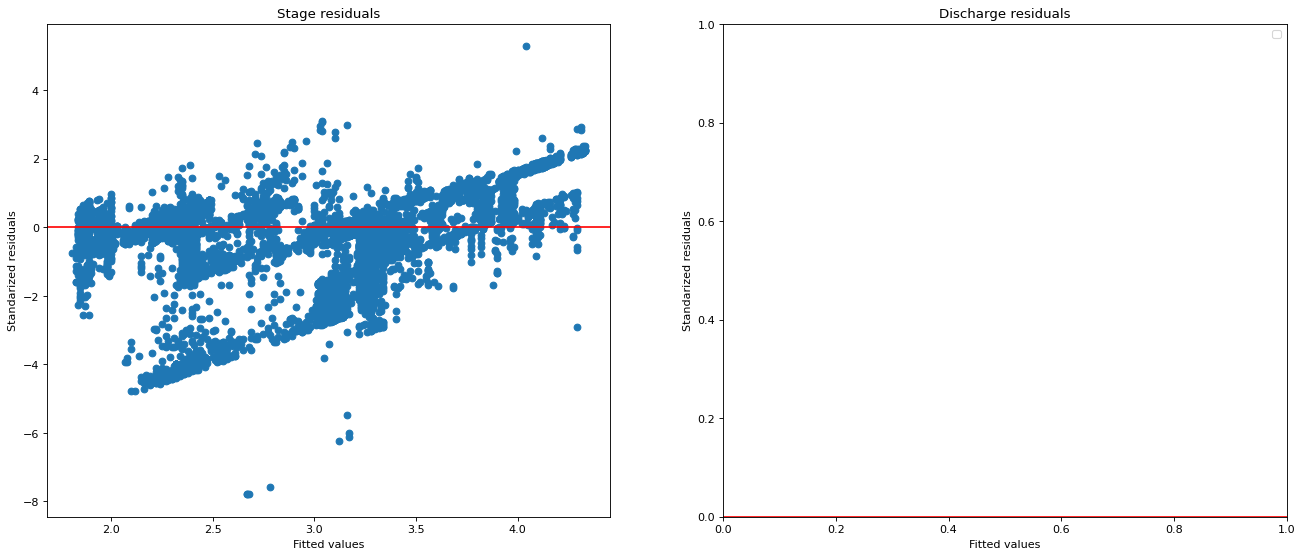

In [26]:
residuals = y_test - y_pred
residuals_std = residuals/residuals.std()

y_real_stage = np.array([i[0] for i in y_test])
residual_stage = np.array([i[0] for i in residuals])

#y_real_discharge = np.array([i[-1] for i in y_test])
#residual_discharge = np.array([i[-1] for i in residuals])


figure, ax = plt.subplots(ncols=2, figsize=(20, 8), dpi=80)

ax[0].scatter(y_real_stage, residual_stage / residual_stage.std(), label="stage residuals")
#ax[1].scatter(y_real_discharge, residual_discharge / residual_discharge.std(), label="discharge residuals")
ax[0].axhline(y=0.0, color='r', linestyle='-')
ax[1].axhline(y=0.0, color='r', linestyle='-')

ax[0].set_title("Stage residuals")
ax[1].set_title("Discharge residuals")

ax[1].set_xlabel("Fitted values")
ax[0].set_xlabel("Fitted values")
ax[1].set_ylabel("Standarized residuals")
ax[0].set_ylabel("Standarized residuals")

plt.legend()
plt.show()

In [27]:
import statsmodels.api as sm
from statsmodels.stats.diagnostic import normal_ad

#figure = sm.qqplot(residual_stage / residual_stage.std(), line ='45', label='stage')
plt.show()

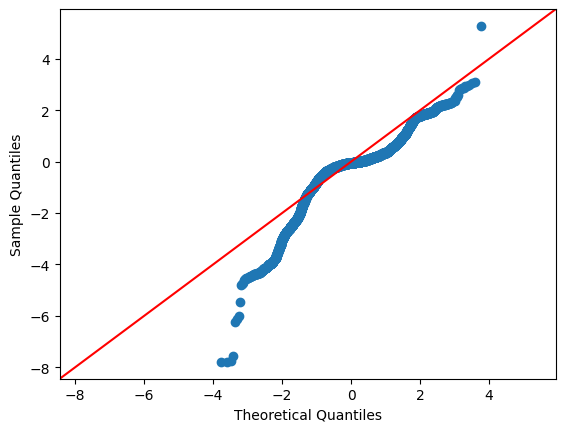

In [28]:
figure = sm.qqplot(residual_stage / residual_stage.std(), line='45', label='discharge')
plt.show()

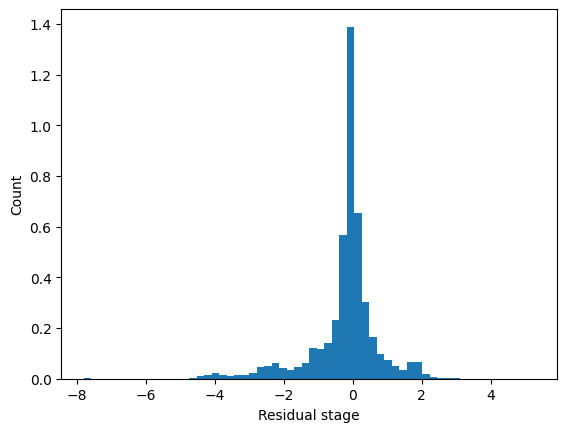

In [29]:
plt.hist(residual_stage / residual_stage.std(), density=True, bins = 60)
plt.ylabel('Count')
plt.xlabel('Residual stage');
plt.show()

In [30]:
"""plt.hist(residual_discharge / residual_discharge.std(), density=True, bins = 60)
plt.ylabel('Count')
plt.xlabel('Residual discharge');
plt.show()"""

"plt.hist(residual_discharge / residual_discharge.std(), density=True, bins = 60)\nplt.ylabel('Count')\nplt.xlabel('Residual discharge');\nplt.show()"

In [31]:
stat, pval = normal_ad(residual_stage / residual_stage.std())
print("p-value:", pval)

if pval < 0.05:
    print("Hay evidencia de que los residuos no provienen de una distribución normal.")
else:
    print("No hay evidencia para rechazar la hipótesis de que los residuos vienen de una distribución normal.")


p-value: 0.0
Hay evidencia de que los residuos no provienen de una distribución normal.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


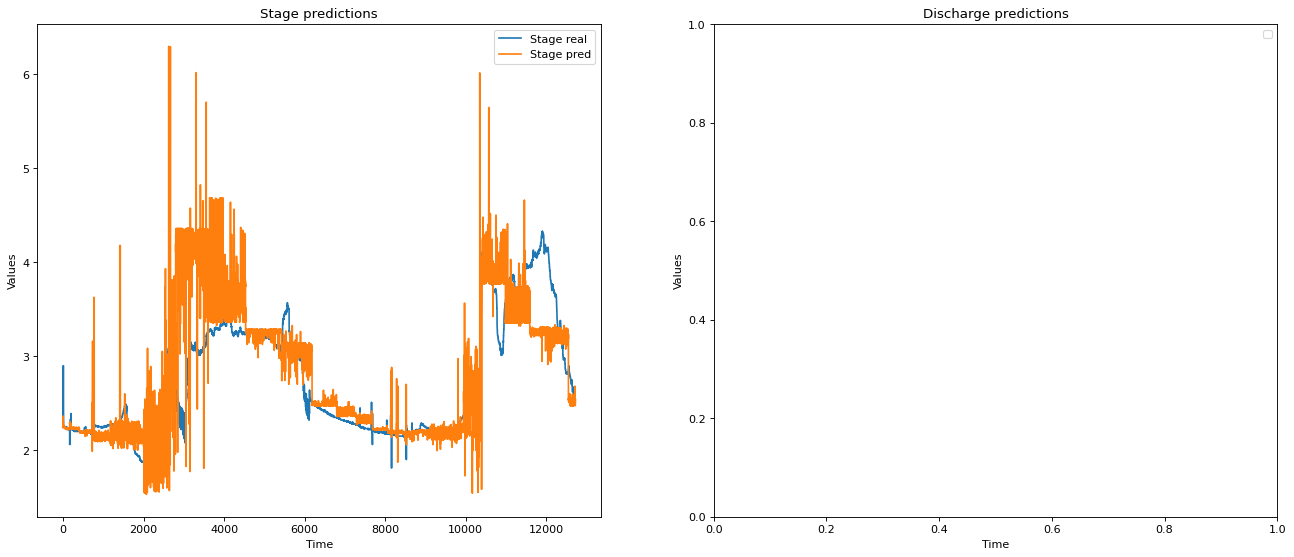

In [32]:
figure, ax = plt.subplots(ncols=2, figsize=(20, 8), dpi=80)

ax[0].plot(np.arange(len(y_test)), y_test, label="Stage real")
ax[0].plot(np.arange(len(y_test)), y_pred, label="Stage pred")

ax[0].set_title("Stage predictions")
ax[1].set_title("Discharge predictions")

ax[1].set_ylabel("Values")
ax[0].set_ylabel("Values")
ax[1].set_xlabel("Time")
ax[0].set_xlabel("Time")

ax[0].legend()
ax[1].legend()
plt.show()